# Age Prediction

In this puzzle, we have to predict the age from the given human faces.

## Setup AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [1]:
# !pip install aicrowd-cli
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/m3PxDjruSbUU3Yg85b6IaiM06cHUnirLUHVeejq0L8Y
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset

We will create a folder name data and download the files there.


In [ ]:
!mkdir data
%aicrowd ds dl -c age-prediction -o data

In [3]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data/train.zip or
        data/train.zip.zip, and cannot find data/train.zip.ZIP, period.
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data/val.zip or
        data/val.zip.zip, and cannot find data/val.zip.ZIP, period.
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
 

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Dataset

In [3]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/sample_submission.csv")

In [4]:
display(train_df.head(5))

print(f"Train: {train_df.shape[0]}, Val: {val_df.shape[0]}, Test: {test_df.shape[0]}")

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10


Train: 4000, Val: 2000, Test: 3000


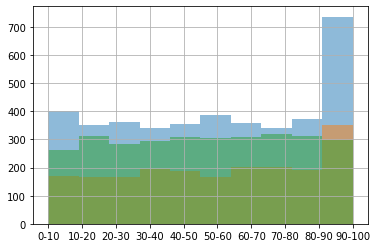

In [5]:
for df in [train_df, val_df, test_df]:
    df.sort_values(by=['age'])['age'].hist(alpha=0.5)

In [19]:
def get_grey_img(row, img_base_path):
  image_path = os.path.join(img_base_path, row['ImageID']+'.jpg')
  imgdata = Image.open(image_path).convert('L')
  imgdata = imgdata.resize((300,300), Image.ANTIALIAS)
  row['image'] = np.asarray(imgdata).flatten()
  return row


In [20]:
train_df = train_df.apply(get_grey_img, axis=1, args=('./data/train',))
val_df = val_df.apply(get_grey_img, axis=1, args=('./data/val',))
test_df = test_df.apply(get_grey_img, axis=1, args=('./data/test',))

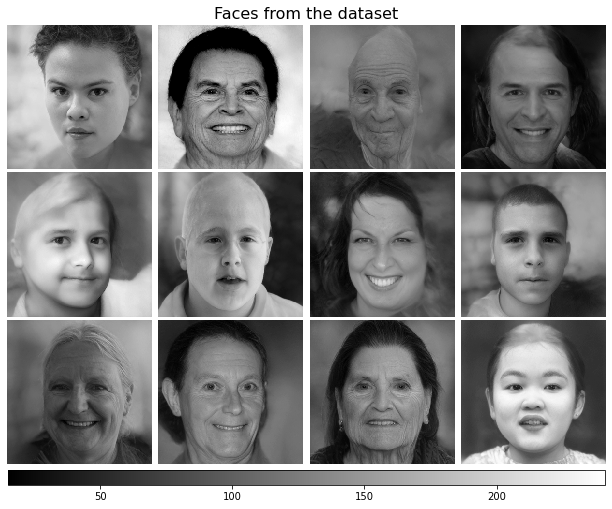

In [22]:
def plot_gallery(title, images, n_col=4, n_row=3, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.1 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, img in zip(axs.flat, images):
        vmax = max(img.max(), -img.min())
        im = ax.imshow(
            img.reshape((300, 300)),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

plot_gallery("Faces from the dataset", train_df.iloc[:12]['image'].values)

## Preprocessing

In [23]:
def preprocess(row, transformer):
    prep_img = transformer.transform(row['image'])
    row['pred'] = prep_img
    return row

In [25]:
from sklearn import decomposition

estimator = decomposition.FactorAnalysis(n_components=50, max_iter=30)
estimator.fit(train_df['image'].values.tolist())

MiniBatchDictionaryLearning(alpha=0.1, n_components=20, n_iter=50,
                            positive_dict=True)

In [33]:
X_train, y_train = estimator.transform(train_df['image'].values.tolist()), train_df['age'].values
X_val, y_val = estimator.transform(val_df['image'].values.tolist()), val_df['age'].values
X_test, y_test = estimator.transform(test_df['image'].values.tolist()), test_df['age'].values

In [32]:
train_df['age'].values

array(['30-40', '80-90', '90-100', ..., '90-100', '30-40', '70-80'],
      dtype=object)

In [34]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [39]:
y_pred = clf.predict(list(X_test))

print("F1:", f1_score(y_pred, y_test, average='weighted'))

F1: 0.1224894421485161
